In [1]:
import pandas as pd

df_pha = pd.read_csv('datasets/Psychosocial_Health_Analysis.csv')
df_pha['problem_category'] = df_pha['problem_category'].str.lower().str.strip()
df_pha['psychological_catehory'] = df_pha['psychological_catehory'].str.lower().str.strip()

df_pha = df_pha[
    (df_pha['problem_category'] == 'stress') | 
    (df_pha['problem_category'] == 'anxiety') |
    (df_pha['psychological_catehory'] == 'stress') |
    (df_pha['psychological_catehory'] == 'anxiety')
    ]

df_pha['label'] = 1
df_pha = df_pha.rename(columns={'Problem_description': 'text'})

df_pha = df_pha.drop(['Age', 'Gender', 'problem_summary', 'problem_category', 'psychological_catehory'], axis=1)

df_pha.head()

,text,label
0,A woman is sharing their challenges as the on...,1
3,"How to increase confidence? Feeling insecure, ...",1
5,"The user is in a complicated situation, caught...",1
6,The user was previously in a relationship but ...,1
8,The user is experiencing emotional turmoil due...,1


In [2]:
df_stress = pd.read_csv('datasets/Stress.csv')

df_stress = df_stress.drop(['subreddit','post_id','sentence_range','confidence','social_timestamp'], axis=1)

df_stress.head()

,text,label
0,"He said he had not felt that way before, sugge...",1
1,"Hey there r/assistance, Not sure if this is th...",0
2,My mom then hit me with the newspaper and it s...,1
3,"until i met my new boyfriend, he is amazing, h...",1
4,October is Domestic Violence Awareness Month a...,1


In [3]:
df_mhc = pd.read_csv('datasets/NLP_Mental_Health_Conversations.csv')

df_mhc['label'] = 1
df_mhc = df_mhc.rename(columns={'Context': 'text'})

df_mhc = df_mhc.drop('Response', axis=1)
df_mhc = df_mhc.drop_duplicates()

df_mhc.head()

,text,label
0,I'm going through some things with my feelings...,1
23,I have so many issues to address. I have a his...,1
70,I have been feeling more and more down for ove...,1
72,I’m facing severe depression and anxiety and I...,1
81,How can I get to a place where I can be conten...,1


In [4]:
# Read in reddit posts from subreddits that are deemed positive. Note: Some datasets are too large, and are split into parts instead.
import re

filepaths = [
    ("datasets/reddit/MadeMeSmile_submissions00.zip", 90),
    ("datasets/reddit/MadeMeSmile_submissions01.zip", 90),    
    ("datasets/reddit/MadeMeSmile_submissions02.zip", 90),
    ("datasets/reddit/MadeMeSmile_submissions03.zip", 90),    
    ("datasets/reddit/MadeMeSmile_submissions04.zip", 90),    
    ("datasets/reddit/MadeMeSmile_submissions05.zip", 90),
    ("datasets/reddit/wholesome_submissions.zip", 600)    
]

df_positive = pd.DataFrame(columns=['selftext'])

for f in filepaths:
    df_temp = pd.read_json(f[0], lines=True)[['selftext']]
    df_temp['selftext'] = df_temp['selftext'].apply(lambda x: re.sub(r'http\S+', '', x))
    df_temp = df_temp[
        (df_temp['selftext'] != '') & 
        (df_temp['selftext'] != '[deleted]') & 
        (df_temp['selftext'] != '[removed]') &
        (df_temp['selftext'].str.contains('removed by reddit', flags=re.IGNORECASE) == False) &
        (df_temp['selftext'].apply(lambda x: len(x.split()) >= 10))
    ].sample(f[1])

    df_positive = pd.concat([df_positive, df_temp], ignore_index=True)

df_positive = df_positive.reset_index(drop=True)

df_positive['label'] = 0
df_positive = df_positive.rename(columns={'selftext' : 'text'})

df_positive.head()

,text,label
0,Got a very happy lady (looks 50ish) at the tol...,0
1,This post will be posted here for the rest of ...,0
2,I had my window open and I heard a little girl...,0
3,Today's good deed story: (well two days) 2018-...,0
4,"Everytine i read or hear this word, no matter ...",0


In [5]:
# Combine all datasets into a single dataframe
df = pd.concat([df_pha, df_stress, df_mhc, df_positive], ignore_index=True)
#df = df_stress
df = df.reset_index(drop=True)

df.head()

,text,label
0,A woman is sharing their challenges as the on...,1
1,"How to increase confidence? Feeling insecure, ...",1
2,"The user is in a complicated situation, caught...",1
3,The user was previously in a relationship but ...,1
4,The user is experiencing emotional turmoil due...,1


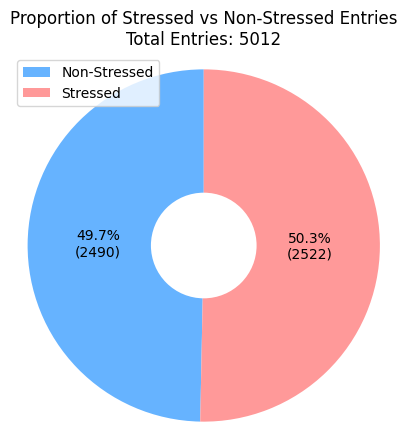

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

label_counts = df['label'].value_counts()

labels = ['Non-Stressed', 'Stressed']

if 0 in label_counts and 1 in label_counts:
    counts = [label_counts[0], label_counts[1]]
    total_entries = label_counts.sum()
else:
    counts = [0, 0]  
    total_entries = 0

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

colors = ['#66b3ff', '#ff9999']

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(counts, colors=colors, autopct=lambda pct: func(pct, counts),
       startangle=90, pctdistance=0.6)

centre_circle = plt.Circle((0,0),0.3,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax.axis('equal')

plt.legend(labels)
plt.title(f'Proportion of Stressed vs Non-Stressed Entries\nTotal Entries: {total_entries}')
plt.show()


In [7]:
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag

nltk.download('omw-1.4')
nltk.download('wordnet') 
nltk.download('wordnet2022')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()
stop_words = list(stopwords.words('english'))

[nltk_data] Downloading package omw-1.4 to /home/brian/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/brian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to
[nltk_data]     /home/brian/nltk_data...
[nltk_data]   Package wordnet2022 is already up-to-date!
[nltk_data] Downloading package punkt to /home/brian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/brian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/brian/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [8]:
# Clean up and lemmatize the texts.

def process_texts(text):

    # Strip and convert text to lower case
    text = text.strip().lower()

    # Remove urls
    text = re.sub(r'http\S+', '', text)
    
    # Remove escape characters
    text = re.sub(r'\@\w+', '', text)

    # Remove emojis
    emoji = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    text = re.sub(emoji, '', text)

    # Remove html tags 
    text = re.sub(r'<.*?>', '', text)
    
    # Remove new line in string form
    text = re.sub(r'\\n', '', text)

    # Replace brackets with space
    text = re.sub(r'[\]\[\)\(]', ' ', text)
    
    # Remove all characters except alphabets
    text = re.sub(r'[^A-Za-z]' ,' ', text)

    # Replace multiple whitespace with single space
    text = re.sub(r'\s\s+', ' ', text)

    # Tokenize the sentence
    tokens = word_tokenize(text)

    # Remove stop words
    tokens = [t for t in tokens if not t in stop_words]

    # POS tag the words
    pos = pos_tag(tokens)

    # Lemmatize all words
    text = []
    for word, tag in pos:
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        text.append(lemmatizer.lemmatize(word, wntag) if wntag else word)

    # Remove single letter words
    for w in text:
        if len(w) <= 1:
            text.remove(w)

    return ' '.join(text)

In [9]:
df['processed_text'] = df['text'].apply(lambda x: process_texts(x))
df.sample(10)

,text,label,processed_text
1515,We still have up until December on this lease ...,0,still december lease together sponsor country ...
4149,I (23f) work as a cleaner which is a very labo...,0,work cleaner labor intensive job privately pro...
1060,"Sometimes it goes into an actual panic attack,...",1,sometimes go actual panic attack often husband...
4095,"Hello everyone, \n\nI’m pretty sure I got the ...",0,hello everyone pretty sure get best present an...
1088,"So I'm unemployed, broke, no car or drivers li...",1,unemployed break car driver licence suspend du...
1950,"Deep breathing, reminding myself that I'm just...",1,deep breathing remind irrationally panic promi...
4640,I now have 😁3\n\n3: but this one takescm\nP it,0,one takescm
547,So here’s he thing. I do have feelings for him...,0,thing feeling intensity level use feel fall on...
3189,About 5 months ago my ex left without fully ex...,1,month ago ex leave without fully explain seem ...
4296,"before going into work yesterday, i stopped at...",0,go work yesterday stop store leave saw coworke...


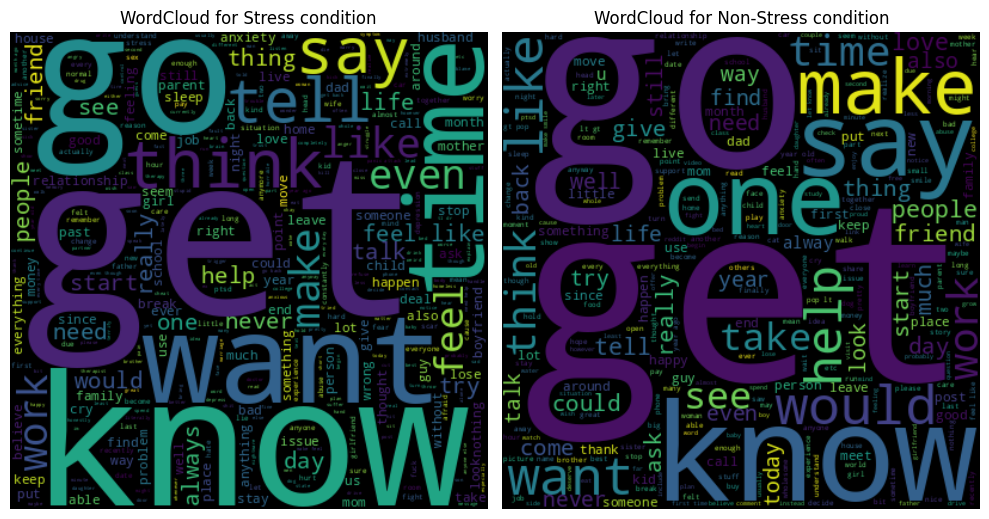

In [12]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fig, axs = plt.subplots(1, 2, figsize=(10, 10))

wc_stress = WordCloud(max_words=2000, width=400, height=400, stopwords=stop_words).generate(" ".join(df[df.label == 1].processed_text))
axs[0].imshow(wc_stress, interpolation='bilinear')
axs[0].set_title('WordCloud for Stress condition')
axs[0].axis('off') 

wc_non_stress = WordCloud(max_words=2000, width=400, height=400, stopwords=stop_words).generate(" ".join(df[df.label == 0].processed_text))
axs[1].imshow(wc_non_stress, interpolation='bilinear')
axs[1].set_title('WordCloud for Non-Stress condition')
axs[1].axis('off')  

plt.tight_layout()
plt.show()

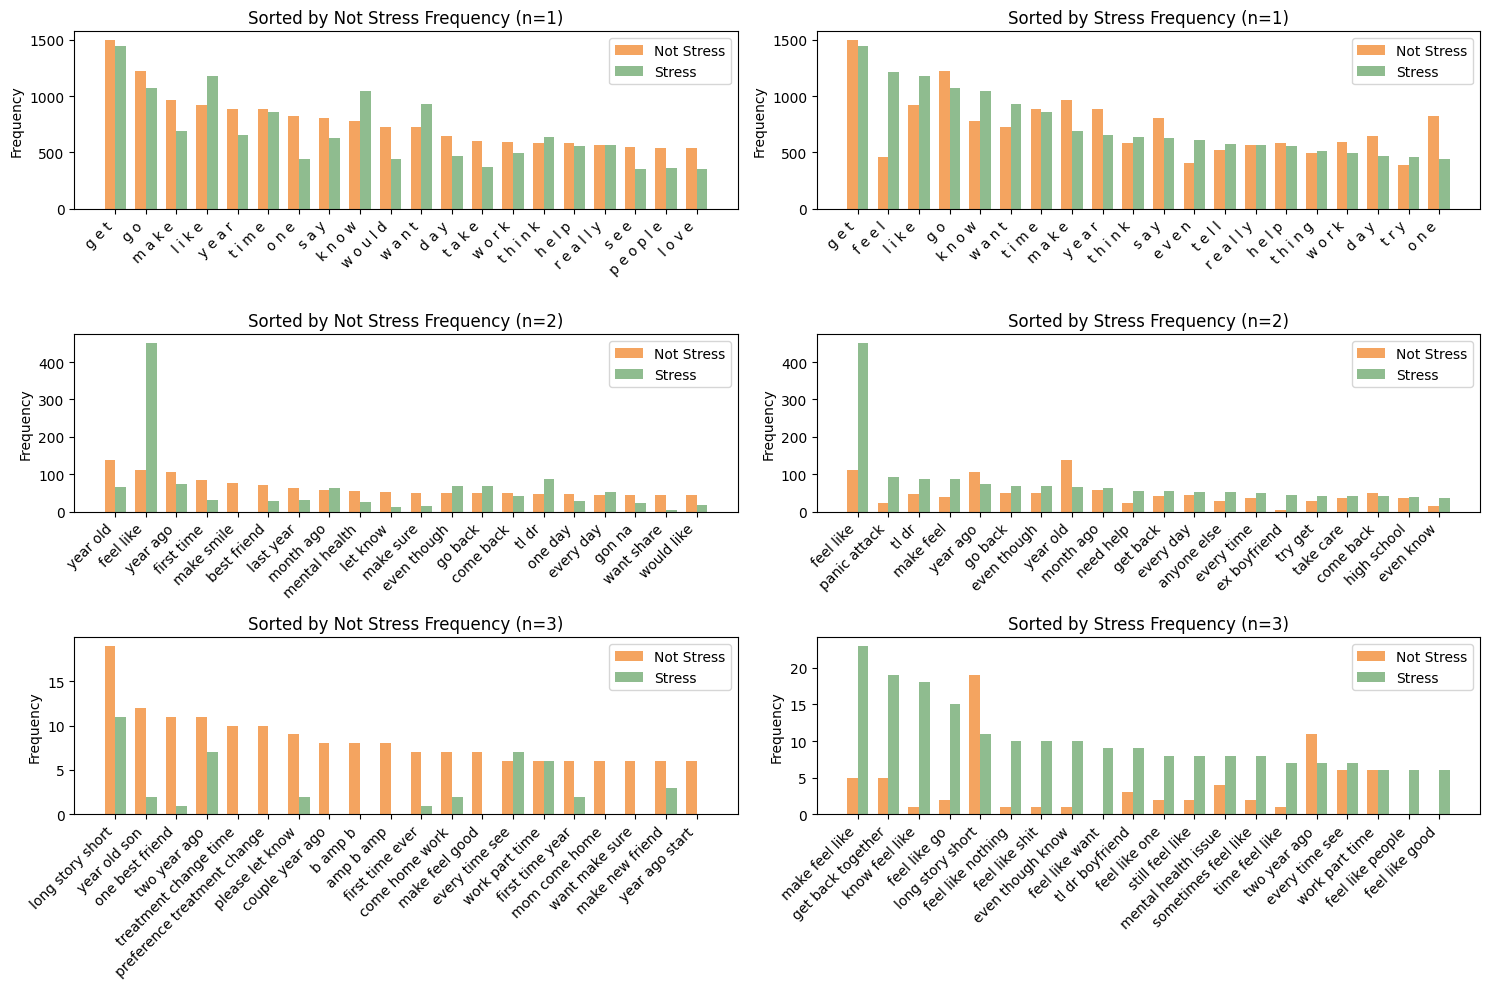

In [85]:
from nltk.util import bigrams, trigrams

# Helper function to get n-grams
def get_ngrams(text, n=1):
    tokens = word_tokenize(text.lower())
    if n == 1:
        return tokens  # Single words
    elif n == 2:
        return list(bigrams(tokens))
    elif n == 3:
        return list(trigrams(tokens))

# Generate and count n-grams frequencies
def count_ngrams(label, n=1):
    ngrams = df[df['label'] == label]['processed_text'].apply(get_ngrams, n=n).explode()
    return ngrams.value_counts().rename(f'label_{label}')

def plot_ngrams(ax, sorted_by_label_0, sorted_by_label_1, n=1):
    indices_0 = range(len(sorted_by_label_0))
    indices_1 = range(len(sorted_by_label_1))
    bar_width = 0.35

    ax[0].bar(indices_0, sorted_by_label_0[f'label_0'], width=bar_width, color='#f4a460', label='Not Stress')
    ax[0].bar([i+bar_width for i in indices_0], sorted_by_label_0[f'label_1'], width=bar_width, color='#8fbc8f', label='Stress')
    ax[0].set_title(f'Sorted by Not Stress Frequency (n={n})')
    ax[0].set_xticks([i + bar_width / 2 for i in indices_0])
    ax[0].set_xticklabels([' '.join(map(str, ngram)) for ngram in sorted_by_label_0.index], rotation=45, ha="right")

    ax[1].bar(indices_1, sorted_by_label_1[f'label_0'], width=bar_width, color='#f4a460', label='Not Stress')
    ax[1].bar([i+bar_width for i in indices_1], sorted_by_label_1[f'label_1'], width=bar_width, color='#8fbc8f', label='Stress')
    ax[1].set_title(f'Sorted by Stress Frequency (n={n})')
    ax[1].set_xticks([i + bar_width / 2 for i in indices_1])
    ax[1].set_xticklabels([' '.join(map(str, ngram)) for ngram in sorted_by_label_1.index], rotation=45, ha="right")

    for a in ax:
        a.set_ylabel('Frequency')
        a.legend()

# Setup the 2x3 grid of plots
fig, axs = plt.subplots(3, 2, figsize=(15, 10))

# Single-word frequencies
freqs_0_words = count_ngrams(0, n=1)
freqs_1_words = count_ngrams(1, n=1)
sorted_by_label_0_words = pd.concat([freqs_0_words, freqs_1_words], axis=1).fillna(0).sort_values(by='label_0', ascending=False).head(20)
sorted_by_label_1_words = pd.concat([freqs_0_words, freqs_1_words], axis=1).fillna(0).sort_values(by='label_1', ascending=False).head(20)
plot_ngrams(axs[0], sorted_by_label_0_words, sorted_by_label_1_words, n=1)

# Bigram frequencies
freqs_0_bigrams = count_ngrams(0, n=2)
freqs_1_bigrams = count_ngrams(1, n=2)
sorted_by_label_0_bigrams = pd.concat([freqs_0_bigrams, freqs_1_bigrams], axis=1).fillna(0).sort_values(by='label_0', ascending=False).head(20)
sorted_by_label_1_bigrams = pd.concat([freqs_0_bigrams, freqs_1_bigrams], axis=1).fillna(0).sort_values(by='label_1', ascending=False).head(20)
plot_ngrams(axs[1], sorted_by_label_0_bigrams, sorted_by_label_1_bigrams, n=2)

# Trigram frequencies
freqs_0_trigrams = count_ngrams(0, n=3)
freqs_1_trigrams = count_ngrams(1, n=3)
sorted_by_label_0_trigrams = pd.concat([freqs_0_trigrams, freqs_1_trigrams], axis=1).fillna(0).sort_values(by='label_0', ascending=False).head(20)
sorted_by_label_1_trigrams = pd.concat([freqs_0_trigrams, freqs_1_trigrams], axis=1).fillna(0).sort_values(by='label_1', ascending=False).head(20)
plot_ngrams(axs[2], sorted_by_label_0_trigrams, sorted_by_label_1_trigrams, n=3)

plt.tight_layout()
plt.show()

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Splitting the dataset
x_train, x_test, y_train, y_test = train_test_split(df['processed_text'], df['label'], stratify=df['label'], test_size=0.2, random_state=42)

pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', LogisticRegression(max_iter=1000))  # Increased max_iter for convergence
])

# Parameters for GridSearchCV
param_grid = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [1, 2, 3],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],  # n-grams
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l2']
}

# GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

# Best parameters and scores
print("Best parameters:", grid_search.best_params_)
print("Training accuracy:", grid_search.score(x_train, y_train))
print("Test accuracy:", grid_search.score(x_test, y_test))

# Classification report
y_pred = grid_search.predict(x_test)
print(classification_report(y_test, y_pred))

Best parameters: {'model__C': 10, 'model__penalty': 'l2', 'tfidf__max_df': 0.5, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Training accuracy: 0.999002244948865
Test accuracy: 0.8015952143569293
              precision    recall  f1-score   support

           0       0.82      0.77      0.79       498
           1       0.79      0.83      0.81       505

    accuracy                           0.80      1003
   macro avg       0.80      0.80      0.80      1003
weighted avg       0.80      0.80      0.80      1003



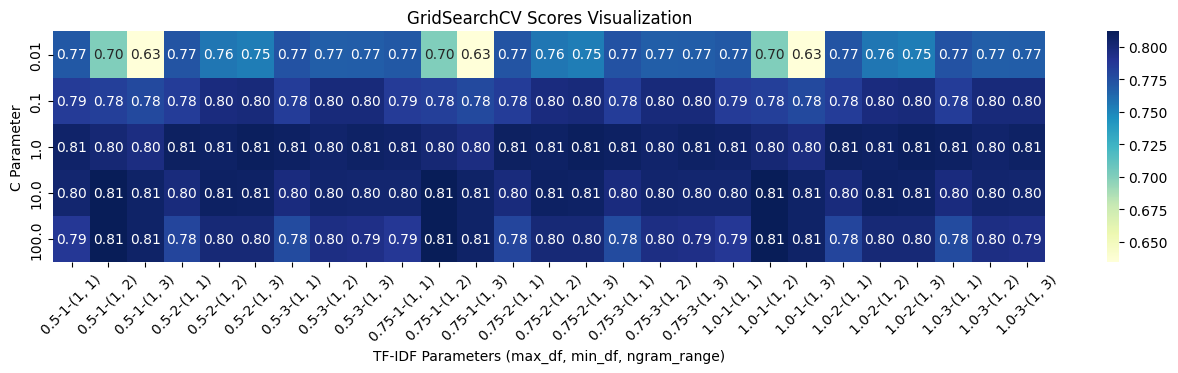

In [82]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results = pd.DataFrame(grid_search.cv_results_)

results = results[['mean_test_score', 'param_tfidf__max_df', 'param_tfidf__min_df', 'param_tfidf__ngram_range', 'param_model__C', 'param_model__penalty']]

pivot_table = results.pivot_table(values='mean_test_score', 
                                  index=['param_model__C'], 
                                  columns=['param_tfidf__max_df', 'param_tfidf__min_df', 'param_tfidf__ngram_range'],
                                  aggfunc='max')

plt.figure(figsize=(16, 3))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt=".2f")
plt.xticks(rotation=45) 
plt.title('GridSearchCV Scores Visualization')
plt.ylabel('C Parameter')
plt.xlabel('TF-IDF Parameters (max_df, min_df, ngram_range)')
plt.show()


In [29]:
# Save model to file
import pickle

with open('model.pkl','wb') as f:
    pickle.dump(grid_search, f)